# Extracting Flooding Areas from NRT Sentinel-1 Satellite Imagery

In [1]:
import os
import pandas as pd                 
import geopandas as gpd                                             # read geospatial data
import dataretrieval.nwis as nwis  
import matplotlib.pyplot as plt
import subprocess                                                   # to run commandline commands
import multiprocessing                                              # get number of cores
from ipyleaflet import Map, basemaps, basemap_to_tiles 
from ipyleaflet import GeoData, LayersControl, ImageOverlay
import ipywidgets as widgets                                        # interactive display
from hydrosar.flood_map import make_flood_map

In [2]:
# get number of cores
logical_cores = multiprocessing.cpu_count()
num_workers = int(logical_cores * 0.8)  # rounds down in case not a whole number
print(f'Number of threads to use: {num_workers}')

Number of threads to use: 8


## Review the water data

Use the [USGS Water Services Instantaneous API](https://waterservices.usgs.gov/test-tools/?service=iv&siteType=&statTypeCd=all&major-filters=sites&format=json&date-type=type-none&statReportType=daily&statYearType=calendar&missingData=off&siteStatus=all&siteNameMatchOperator=start) to retreive data for a USGS Gage in Frankfort, Kentucky. 

Dataretrieval Python Documentation:
    [https://doi-usgs.github.io/dataretrieval-python/index.html](https://doi-usgs.github.io/dataretrieval-python/index.html)  
    I will used the dataretrievel.nwis.get_iv

In [3]:
# set up variables for the instantaneous values (iv)
# query ~60 days of data
sites= '03287500'                      # site number for USGS Gage in Frankfort
start = '2025-01-15'                   # filter for the range of start date
end = '2025-03-15'                     # and end data
parameterCd = ["00060", "00065"]       # parameter codes for gage discharge in cubic feet/second
                                       # and height in feet                                       

In [4]:
# create a metadata link and dataframe
water_df, water_md = nwis.get_iv(
    sites=sites,
    start=start,
    end=end,
    parameterCd=parameterCd,
    multi_index=True,
)
print(f'Metadata Link: {water_md}')
print(water_df.columns)
print(f'The stream gage table has {water_df.shape[1]} rows and {water_df.shape[0]} colummns')

Metadata Link: NWIS_Metadata(url=https://waterservices.usgs.gov/nwis/iv?format=json&parameterCd=00060%2C00065&startDT=2025-01-15&endDT=2025-03-15&sites=03287500)
Index(['site_no', '00060', '00060_cd', '00065', '00065_cd'], dtype='object')
The stream gage table has 5 rows and 5756 colummns


#### Dataframe cleaning
- drop columns
- rename columns
- reset index
- convert datatime to date

In [5]:
def clean_water_df(df):
    # Drop site_no and columns that end in cd
    cols_to_drop = ['site_no','00060_cd', '00065_cd']
    df = df.drop(columns=cols_to_drop, axis=1)

    # rename columns
    cols_to_rename = {'00060': 'discharge (cubic feet)', '00065': 'stream height (feet)'}
    df = df.rename(columns=cols_to_rename)

    # reset index so we can use datetime
    df = df.reset_index()           
    df['date'] = pd.to_datetime(df['datetime'], errors='coerce').dt.date
    df

    new_df = df.iloc[:, [3, 2, 1]]
    new_df

    return new_df

In [6]:
# call function to clean
clean_water_df = clean_water_df(water_df)

In [7]:
print(f'\n{clean_water_df.dtypes}')         # check dtype
clean_water_df.head(1)                      # See actual data


date                       object
stream height (feet)      float64
discharge (cubic feet)    float64
dtype: object


,date,stream height (feet),discharge (cubic feet)
0,2025-01-15,9.17,7490.0


#### Group the data by date and return max value for stream height and discharge for that day. 

In [8]:
clean_water_df_groupby = clean_water_df.groupby('date', as_index=False).agg({
    'stream height (feet)': 'max',
    'discharge (cubic feet)': 'max'
})
print(f'The new dataframe has {clean_water_df_groupby.shape[1]} columns and {clean_water_df_groupby.shape[0]} rows.')
clean_water_df_groupby.tail(3)

The new dataframe has 3 columns and 61 rows.


,date,stream height (feet),discharge (cubic feet)
58,2025-03-14,8.93,6580.0
59,2025-03-15,9.42,8490.0
60,2025-03-16,11.29,18200.0


#### Plot the data

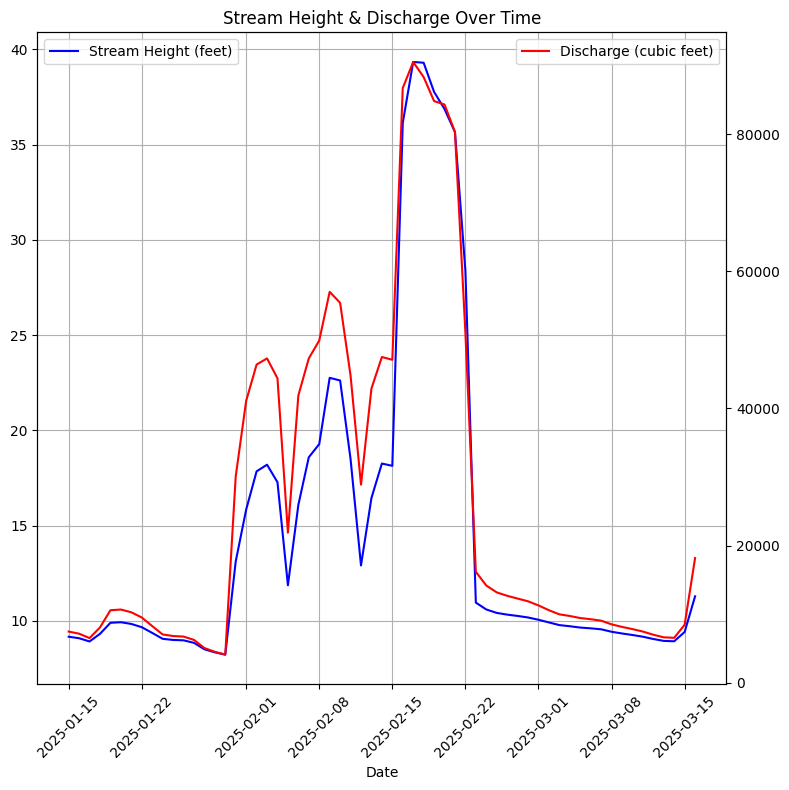

In [9]:
gage_data = clean_water_df_groupby

# have the plot read date as datetime, otherwise it looks messy
gage_data['date'] = pd.to_datetime(gage_data['date'])

# set x and y values
x = gage_data['date']
y1 = gage_data['stream height (feet)']
y2 = gage_data['discharge (cubic feet)']

fig,ax = plt.subplots(figsize=(8,8))

ax.plot(x, y1, color = 'b', label='Stream Height (feet)')
ax2 = ax.twinx()
ax2.plot(x,y2, color='r', label='Discharge (cubic feet)')
ax.set_xlabel('Date')
ax.set_title('Stream Height & Discharge Over Time')

# Add legends
ax.legend(loc='upper left')  
ax2.legend(loc='upper right')

# rotate the x-axis labels to fit more
ax.tick_params(axis='x', rotation=45)  

ax.grid(True)

# plot
fig.tight_layout()
plt.show()

___
## Download Imagery

1. Create a function that downloads two scenes and processing elevation data.
2. Create a function that setups up a dataframe
3. Create dataframe and download data

In [ ]:
# download function
def box_download(df):
    out_folder = "data"
    download_zip = os.path.join(out_folder, 'file.zip')
    for index, row in df.iterrows():
        link = row['link']
        unzipped_folder = row['scene_folder']
        unzip_path = os.path.join(out_folder, unzipped_folder)

        cmd = f"curl -L -o {download_zip} {link} && unzip {download_zip} -d {out_folder}"
        
        if not os.path.exists(unzip_path):
            subprocess.run(cmd, shell=True, check=True)
            # delete downloaded zip file.
            os.remove(download_zip)
        else:
            print(f'Extracted Files already exist for "{unzipped_folder}"')

In [ ]:
# dataframe function
def create_scenes_df():
    
    """
       SAR Data:
        These files were obtained using the ASF Vertex Data Search.
        They were submitted for Radio Terrain Correctiom.
        radiometry: gamma0
        scale: power
        pixel spacing: 10m
       
        Digital Elevation Model processing:
         The dem processing folder contains the DEM used for radio-
         terrain correction and derivative products used to create 
         a HAND and water mask.
    """

    box_data = {
        'zipfile': ['S1A_IW_20250124T233956_DVP_RTC10_G_gdufem_8285.zip',
                    'S1A_IW_20250217T233955_DVP_RTC10_G_gpufem_0598',
                    'dem_processing.zip'],
        'link': ['https://ky.box.com/shared/static/lchrmjmb5cy1jdtsq5wfp5y3hao5cs0d.zip',
                'https://ky.box.com/shared/static/rz15mqljj1m0tcejhu647haey6sfrfkf.zip']
            }
    scenes_df = pd.DataFrame(data=box_data)

    # calculate some fields
    scenes_df['scene_folder'] = scenes_df['zipfile'].apply(lambda x: os.path.splitext(x)[0])
    if not scenes_df['scene_folder'].eq('dem_processing.zip').any():
        scenes_df['input_dem'] = scenes_df['scene_folder'] + '_dem.tif'
        scenes_df['rgb'] = scenes_df['scene_folder'] +  '_rgb.png'
        scenes_df['vv'] = scenes_df['scene_folder'] + '_vv.tif'
        scenes_df['vh'] = scenes_df['scene_folder'] + '_vh.tif'
        scenes_df['shapefile'] = scenes_df['scene_folder'] + '_shape.shp'
    else:
        print("dem processing is not a scene")
    return scenes_df

In [12]:
# make sure the data folder is present
if not os.path.exists('data'):
    os.makedirs('data')
scenes_df = create_scenes_df()
scenes_df

ValueError: All arrays must be of the same length

Download could take several minutes, depending upon bandwidth.  Zipped up, the scenes are over 10gb in size each.  The dem products folder is ~2.5gb.

In [ ]:
# download data from Box
box_download(scenes_df)

In [ ]:
base_scene = scenes_df.at[0,'scene_folder']
flood_scene = scenes_df.at[1,'scene_folder']
dem_folder = scenes_df.at[2, 'scene_folder']
print(f'Base Scene Directory:  {base_scene}\nFlood Scene Directory: {flood_scene}\nDEM products Directory: {dem_folder}')

#### Review the Scene folders

The folders contain several files.  Each image (png or tif) has a corresponding metadata (xml) file.  The folder also includes a shapefile (\*_shape.\*) and a google kmz which display a geometry on a map.  

There is also a **README.md** file in each folder that breaks down how to undertand the file name and what is included in the scene folder.  
- Base Scene [README](./base_granule_README.md)
- Crisis Scene [README](./crisis_granule_README.md)

Let's take a look at some of the files to get an idea of what we're looking at.

In [ ]:
# read in base image shapefile
base_shapefile = (f'data/{base_scene}/{base_scene}_shape.shp')

# read in shapefile to geodataframe
gdf_base_shapefile = gpd.read_file(base_shapefile)
print(f'source projection: {gdf_base_shapefile.crs}')

# redefine the projection to work with the map
gdf_base_shapefile = gdf_base_shapefile.to_crs('EPSG:4326')
print(f'redefined projection: {gdf_base_shapefile.crs}')

In [ ]:
# read in geodataframe to a ipyleaflet GeoData
base_geo_data = GeoData(geo_dataframe = gdf_base_shapefile,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.1, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'base Geometry')

In [ ]:
m = Map(
    basemap=basemap_to_tiles(basemaps.CartoDB.Positron),
    center=(38, -85.5),
    zoom=7.3
)
m.add(base_geo_data)
# m.add(LayersContol())
m

In [ ]:
# display RGB Composite File
rgb_png =  os.path.join('data', flood_scene, f'{flood_scene}_rgb.png')
print(rgb_png)
file = open(rgb_png, "rb")
image = file.read()
image_widget = widgets.Image(
    value=image,
    format='png',
    width=300,
    height=400,
)
print("Note how we can see the Ohio River starting near the uppermost right corner,\nextending to middle on the left.  This is the derived RGB image.  It will\nnot be used for analysis.")
display(image_widget)

___
## Flood Mapping

Due to time constraints (i.e, processing imagery takes time), some processes like the Height Above Natural Drainage *HAND*, clipping clipping the Digital Elevation Model *DEM* to the scene extent, and create a water extent map were creating using raster calulation functions in ArcGIS Pro and QGIS. I also downloaded [SNAP](https://step.esa.int/main/download/snap-download/) and ran through a couple tutorials on how to process less processed data.

 In addition, some issues arose with the scenes themselves because of how I used the Vertex OnDemand Processing.  To not get too into the details, this had to do with transforming the raster scale from power to decibel.  I ordered decibel, which is what the final calculations call for, but the HydroSAR module expects power and peforms those transformations in its water map raster creation.  I was able to calculate the values to create the water extent in QGIS. This file [water_extent.tif](data/dem_processing/water_extent.tif) was placed in the dem processing folder and used in the *make_flood_map()* function.

Set up flood processing
- variables
- create water raster
- create flood map

In [ ]:
# make sure we have somewhere to park the processed data
flood_processing = 'data/crisis_scene_processing'
if not os.path.exists(flood_processing):
    os.makedirs(flood_processing)

scene_folder = os.path.join('data', flood_scene)
dem_processing = 'data/dem_processing'

# flood map variables
flood_raster = os.path.join(scene_processing, 'flood_map.tif')
vv_raster = os.path.join(scene_folder, scene_df['vv'][1])
water_extent_raster = os.path.join(dem_processing, 'water_extent.tif')
hand_raster = f'{dem_processing}/hand.tif'
hand_clipped = os.path.join(dem_processing, 'hand_clip.tif')

---
Flood map function, took nearly 15 minutes on my Mac Studio

In [ ]:
# run make_flood_map function
if not os.path.exist(flood_raster)
make_flood_map(
    flood_raster,
    vv_raster,
    water_extent_raster,
    hand_raster
)